### 문장 단위 쪼개기



In [55]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('punkt')
nltk.download('vader_lexicon')

daraz = pd.read_csv("C:\\Users\\rud92\\Machine_learning_Project\\Daraz Online Shopping App.csv")


### 문장 단위로 분해 & 새로운 DF 만들기 
new_rows = []
for idx, row in daraz.iterrows():
    original_row_number = idx

    content_text = row['content']
    score = row['score']
    
    sentences = sent_tokenize(content_text)
    

    for sent in sentences:
        new_rows.append({
            'original_row_number': original_row_number,  
            'sentence': sent.strip(), 
            'score': score
        })

df_sentences = pd.DataFrame(new_rows)

print(df_sentences.head(0))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rud92\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rud92\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Empty DataFrame
Columns: [original_row_number, sentence, score]
Index: []


In [57]:
df_sentences.head(6)

##문장 단위로 잘 나뉨

,original_row_number,sentence,score
0,0,"App is now bombarded with ads, making it feel ...",3
1,0,The website really has lost its class.,3
2,0,They charge you for doing cash on delivery.,3
3,0,"Ads pop up after every single tap, which is fr...",3
4,0,But I have to give props to their customer ser...,3
5,1,The search is by far the most atrocious aspect...,1


#### 전처리 + 피처벡터화 

In [66]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import sent_tokenize
import pandas as pd
import re
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


##content 전처리

# 불용어 리스트
custom_stopwords = set(stopwords.words('english')).union({"want", "on", "buy", "give", "every", "single", "pop", "one", "look", "is", "the", "and", "it", "very", "to", "this", "for", "of", "in", "on", "have"})

# 어간, 표제어 추출기  --> 어근이 제대로 안 나와서 PorterStemmer라는 걸 추가로 활용했어요!
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# 텍스트 전처리 함수 정의
def preprocess_text(text):
    if not isinstance(text, str):  # NaN 방지
        return ""

    # 클렌징
    text = text.lower() 
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip() 

    # 토큰화
    tokens = word_tokenize(text)

    # 불용어 제거
    tokens = [word for word in tokens if word not in custom_stopwords]

    # 어근 추출 및 표제어 추출(pos 태그 verb로 설정)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos="v") for word in tokens]

    #중복 단어 제거
    tokens = list(dict.fromkeys(tokens))

    return ' '.join(tokens)


df_sentences['preprocessed_sentence'] = df_sentences['sentence'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rud92\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rud92\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rud92\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [70]:
# 피처벡터화

# 데이터 나누기
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df_sentences['preprocessed_sentence'], test_size=0.2, random_state=42)


# 1.2. TF-IDF 기반의 벡터화
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(min_df=3, max_features=5000)
tfidf_vect.fit(X_train)
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

# 2. 성능 비교

# 2.1. 자주 등장하는 단어 출력 함수
def top_words(vectorizer, X, top_n=30):
    words = vectorizer.get_feature_names_out() # 벡터화된 데이터에서 고유한 단어들을 반환하는 함수
    word_freq = X.sum(axis=0).A1  # .sum(axis=0)은 각 단어의 등장횟수 계산
                                   # .A1은 희소->밀집 행렬 변환 메서드
    wofr_pair = list(zip(words, word_freq)) # 단어-등장횟수 페어 만들기
    wofr_pair = sorted(wofr_pair, key=lambda x: x[1], reverse=True)[:top_n] # 내림차순 정렬 후 상위 n개 추출
    return wofr_pair
 

# 2.3. TF-IDF 상위 단어 추출
tfidf_top_words = top_words(tfidf_vect, X_train_tfidf)
print("TF-IDF에서 자주 등장하는 상위 30개 단어:")
for word, count in tfidf_top_words:
    print(f"{word}: {count}")

TF-IDF에서 자주 등장하는 상위 30개 단어:
app: 4290.528572425962
good: 3515.5133172262163
daraz: 2861.3245014472877
shop: 2737.7211196891008
product: 2433.133289208534
online: 2072.1448553433515
order: 1797.1966244311366
delivery: 1771.8664539519502
best: 1615.401787506204
service: 1538.2408179716879
time: 1413.572320542268
experience: 1245.8972354800992
bad: 1205.5865326185112
use: 1135.4139289325194
thing: 1105.6462439604463
thank: 1070.1814600695184
quality: 987.3967350049185
get: 975.2713881684317
like: 948.7785091322697
love: 941.8449950397526
item: 936.4495451970122
easy: 930.8417678735988
dont: 925.1268880064467
nice: 915.5528475472279
great: 863.7093907355716
much: 808.72777825655
worst: 789.2951133716779
customer: 777.7009257409891
charge: 763.8938655058721
show: 753.4903826297839


#### 오버샘플링

오버 샘플링의 경우 별점 내용 때문에 도입한 내용이었는데, 문장 단위 분류 후 감성 분석 점수를 확인하는 과정에서는 별점 정보를 꼭 사용해야 할까...? 
별점 정보는 감성 점수랑 비교해서 보는 과정이 있으면 좋을 것 같아서 넣었음.
그러나 딱히 오버 샘플링이 필요하지 않아 생략했음

#### 감성 분석 

In [76]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

df_sentences['sentiment_score'] = df_sentences['preprocessed_sentence'].apply(lambda x: sia.polarity_scores(x)['compound'])

print(df_sentences[['preprocessed_sentence', 'sentiment_score']])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rud92\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                   preprocessed_sentence  sentiment_score
0      app bombard ad make feel cheap fraudulent website          -0.4939
1                              website really lose class          -0.4576
2                                   charge cash delivery           0.0000
3                  ad tap frustrate want bombard useless          -0.6705
4                   prop customer service delivery whole           0.0000
...                                                  ...              ...
96689                                           easy use           0.4404
96690                                           love app           0.6369
96691         helpful thankyou thankful team daraz happy           0.8807
96692                                easy wasy shop home           0.4404
96693                                   amaze unique app           0.5423

[96694 rows x 2 columns]


In [78]:
df_sentences

,original_row_number,sentence,score,preprocessed_sentence,sentiment_score
0,0,"App is now bombarded with ads, making it feel ...",3,app bombard ad make feel cheap fraudulent website,-0.4939
1,0,The website really has lost its class.,3,website really lose class,-0.4576
2,0,They charge you for doing cash on delivery.,3,charge cash delivery,0.0000
3,0,"Ads pop up after every single tap, which is fr...",3,ad tap frustrate want bombard useless,-0.6705
4,0,But I have to give props to their customer ser...,3,prop customer service delivery whole,0.0000
...,...,...,...,...,...
96689,53996,Very easy to use.,5,easy use,0.4404
96690,53996,I love this app.,5,love app,0.6369
96691,53997,This is very helpful thankyou very very thankf...,5,helpful thankyou thankful team daraz happy,0.8807
96692,53998,Easy wasy to shop at home,4,easy wasy shop home,0.4404


   original_row_number  avg_sentiment_score  score
0                    0            -0.324400      3
1                    1            -0.132225      1
2                    2             0.032800      1
3                    3            -0.154888      3
4                    4            -0.146529      1


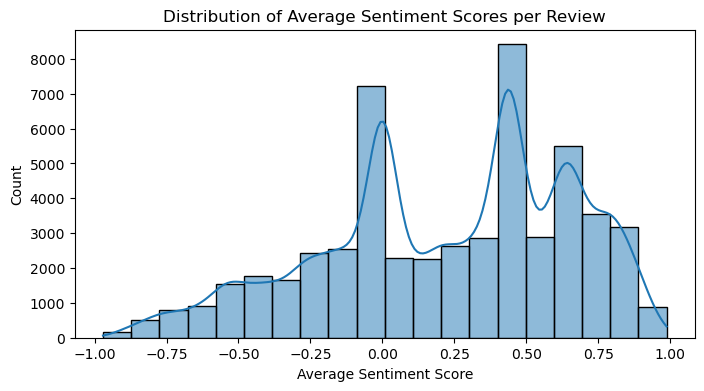

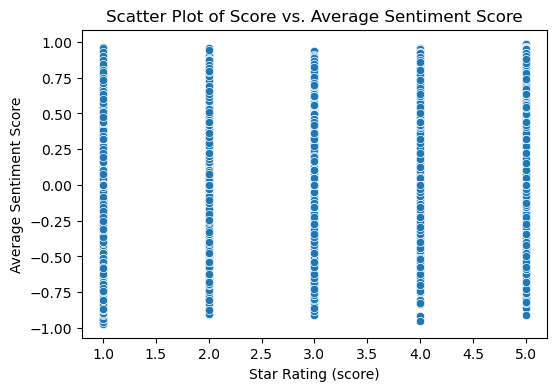

Correlation between star rating and average sentiment score: 0.6745


In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_review_sentiment = (
    df_sentences
    .groupby('original_row_number')['sentiment_score']
    .mean()
    .to_frame('avg_sentiment_score')  
)

df_review_sentiment = df_review_sentiment.join(daraz['score'])

df_review_sentiment.reset_index(inplace=True)

print(df_review_sentiment.head())


# 리뷰별 평균 감성 점수와 별점
plt.figure(figsize=(8,4))
sns.histplot(df_review_sentiment['avg_sentiment_score'], kde=True, bins=20)
plt.title('Distribution of Average Sentiment Scores per Review')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Count')
plt.show()

# 별점, 평균 감성 점수 간의 관계
plt.figure(figsize=(6,4))
sns.scatterplot(data=df_review_sentiment, x='score', y='avg_sentiment_score')
plt.title('Scatter Plot of Score vs. Average Sentiment Score')
plt.xlabel('Star Rating (score)')
plt.ylabel('Average Sentiment Score')
plt.show()

# 상관계수
corr_value = df_review_sentiment['score'].corr(df_review_sentiment['avg_sentiment_score'])
print(f"Correlation between star rating and average sentiment score: {corr_value:.4f}")